# Sentiment Anlysis

Related paper : [IntradayonlineinvestorsentimentandreturnpatternsintheU.S.stockmarket](https://drive.google.com/open?id=1L8bS8vNTXS-HWToP4zMpqfT308n-LxZb)

Lecture on sentiment analysis: [Project](https://drive.google.com/open?id=0B0rdK44Elj9RZzdYMnJzaTREaHlhOUlmNGd2Qzg3RFJTSDBn)

## Steps:

1. Clean the text
2. Build a lexicon
3. Build an ML model
4. Compare with true value: [L1/L2](http://www.thomas-renault.com/data.php)
5. Compute accuracy

In [1]:
import pandas as pd
import pymongo
from pymongo import MongoClient

## Create connection with Mongo

In [2]:
client = MongoClient('localhost', 27017)

### Client is the database
db = client['StockTwitClass101']

## Step 1: Clean the text

1. Keep only twit with sentiment either `Bullish` or `Bearish` and remove multiple stock twits
2. take negation into account, we add the prefix "negtag_" to all words following "not","no","none","neither","never" or “nobody”
3. Convert emoji ;):):-)=):D as "emojipos"  :( :-( =( as"emojineg
4. Convert digit to "_digit"
5. Remove when mention a user
6. lemmatize corpus
2. Remove Stop words


In [3]:
#cursor = db.messages.find({"sentimen": { "$ne": "Neutral" }})
#for document in cursor:
#    if len(document['symbols']) == 2: 
#        print(document['body'])

### Keep only twit with sentiment either Bullish or Bearish and remove multiple stock twits

In [4]:
query ={
    "sentiment":{ "$ne": "Neutral" }
}
df = pd.DataFrame(list(db.messages.find(query)))

df['count_stock'] = df['symbols'].apply(lambda x: len(x))

df_toanalyse = df.copy()

df_toanalyse = df_toanalyse[df_toanalyse['count_stock'].isin([1])]

df_toanalyse.shape

(29316, 9)

In [5]:
df_toanalyse.groupby('sentiment')['sentiment'].count()

sentiment
Bearish     8548
Bullish    20768
Name: sentiment, dtype: int64

### take negation into account

- "not","no","none","neither","never" or “nobody”

In [6]:
df_toanalyse['body_'] = df_toanalyse['body'].replace(regex={r"\bnothing\b": 'nothing_negword',
                                    r"\bno\b": 'no_negword',
                                    r"\bnone\b": 'none_negword',
                                    r"\bneither\b": 'neither_negword',
                                    r"\bnever\b": 'never_negword',
                                    r"\bnobody\b": 'nobody_negword'
                                   })

### Convert emojis

**Positive emojis**

- `;)`; `:)`; `:-)`; `=)`; `:D`
    - as emojipos

**Negative emojis**

- `:(`, `:-(`, `=(`
    - as emojineg

In [7]:
#df_toanalyse[df_toanalyse['user'].isin(['ricardotubbsvicelord'])]['body']

### Convert digit to "_digit"

In [8]:
df_toanalyse['body_'] = df_toanalyse['body_'].replace(regex={r"\d+": 'isDigit'})

### Remove @USER

In [9]:
df_toanalyse['body_'] = df_toanalyse['body_'].replace(regex={r"([@?])(\w+)\b": 'user'})

### Remove unicode issue

- `&#`

In [10]:
df_toanalyse['body_'] = df_toanalyse['body_'].replace(regex={r"\b&#\b": ' '})

### to lower

In [11]:
df_toanalyse['body_'] = df_toanalyse['body_'].str.lower()

### lemmatize corpus

In [12]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /Users/thomas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/thomas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thomas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
from nltk.stem import WordNetLemmatizer

In [14]:
lemmatizer = WordNetLemmatizer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()

In [15]:
def lemmatize_text(text):
    lem =  [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    document = ' '.join(lem)
    return document

In [16]:
df_toanalyse['body_lemmatize'] = df_toanalyse['body_'].apply(lemmatize_text)

### Remove Stop word

Using Scikit learn library

In [17]:
df_toanalyse.head(2)

,_id,body,created_at,id,sentiment,sentiment_,symbols,user,count_stock,body_,body_lemmatize
0,5d8e4264a840b5ab5bac84a0,$BTC.X the bottom is 7960...it is written,2019-09-27T17:09:13Z,178878941,Bullish,1,[Bitcoin BTC/USD],ricardotubbsvicelord,1,$btc.x the bottom is isdigit...it is written,$btc.x the bottom is isdigit...it is written
1,5d8e4264a840b5ab5bac84a2,$BTC.X When September futures expire this thin...,2019-09-27T17:08:38Z,178878838,Bullish,1,[Bitcoin BTC/USD],carlsagan,1,$btc.x when september futures expire this thin...,$btc.x when september future expire this thing...


In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

In [19]:
count_vect = CountVectorizer(max_features=1500,
                             min_df=10,
                             max_df=0.7,
                             stop_words=stopwords.words('english')
                            )

In [20]:
X_train_counts = count_vect.fit_transform(df_toanalyse['body_lemmatize'])
X_train_counts.shape

(29316, 1500)

Example of tokenisation

In [21]:
i = 0
for key, value in count_vect.vocabulary_.items():
    if i < 5:
        print(key, value)
    else:
        break
    i+=1


bottom 153
isdigit 685
september 1164
future 523
expire 435


As in the lecture, we can check the matrix in a Dataframe

In [22]:
count_vect.get_feature_names()
len(X_train_counts.toarray())

29316

In [23]:
count_vect.vocabulary_.get(u'algorithm')

34

In [24]:
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.datasets import load_hobbies

In [27]:
features = count_vect.get_feature_names()

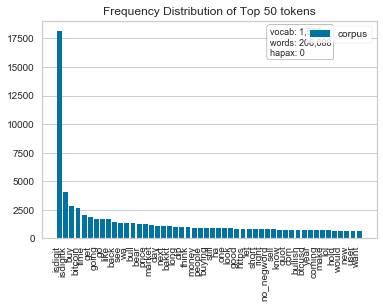

In [28]:
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(X_train_counts)
visualizer.poof()

### 